In [349]:
import torch
import pandas as pd
import numpy as np
import pickle
import subprocess

from scipy.stats import gaussian_kde, ttest_ind, f_oneway, kstest, laplace, norm

from scripts.covdb import utils

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from matplotlib import colors
import seaborn as sns
plt.rcParams['font.family'] = 'Times New Roman'

## Read in data

In [2]:
infectivity_date = '2024-02-05'

with open(f'model_infectivity/{infectivity_date}/mcmc_chain.pkl', 'rb') as f:
    inf_traces = pickle.load(f)
inf_data = torch.load(f'model_infectivity/{infectivity_date}/mcmc_input_data.pt')

In [3]:
escape_date = '2025-06-26'
sb = .6

escape_results = torch.load(f'model_covdb/results.{escape_date}.sb{sb}.pt')
escape_traces = escape_results['traces']
escape_data = escape_results['data']

In [4]:
import os
os.chdir('scripts/covdb/')
plasma_lite = utils.load_plasma_lite()
os.chdir('../../')

In [5]:
# Manhattan plot
def setup(ax, ylim):
    options= dict()
    options['xlim'] = [0, 1273]
    options['ylim'] = ylim #[-1, 1]
    
    ax.set_xlim(options['xlim'])
    ax.set_ylim(options['ylim'])
    
    ax.set_ylabel('Mutation effect')
    ax.set_xlabel('Spike AA Position')

    return options

def get_positions(mutations):
    coefficients = mutations.copy()
    
    positions = [int(''.join(filter(str.isdigit, c))) for c in coefficients] #[int(c[1:-1]) for c in coefficients]
    return positions, coefficients

def plot_coef(ax, effects, positions, mutations, options):
    ax.plot(positions, effects, 'ro')
    
    texts = []
    for i, (pos, fea) in enumerate(zip(positions, mutations)):
        x = pos
        y = effects[i]
        text = fea #+ '\n' + '{:1.2f}'.format(y)
        texts.append(ax.annotate(text, xy=(x, y), xytext=(x, y), fontsize=8))

    # adjust_text(texts);
    
    ax.set_xlim(options['xlim'])
    
def plot_regions(ax, options):
    regions = {'NTD':[13,304],
               'RBD':[417,505],
               # '':[438, 508], # RBM
               'FCS':[672,709],
               'FP':[788, 806],
               'IFP':[816, 833],
               'HR1':[918,983],
               'HR2':[1162,1203]}
    
    for r in regions:
        ax.vlines(regions[r], options['ylim'][0], options['ylim'][1], linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
        ax.fill_between(regions[r], options['ylim'][0], options['ylim'][1], color='tab:blue', alpha=0.1)
        ax.text(np.mean(regions[r]), options['ylim'][1]*0.95, r, ha='center', va='top', fontsize=7)

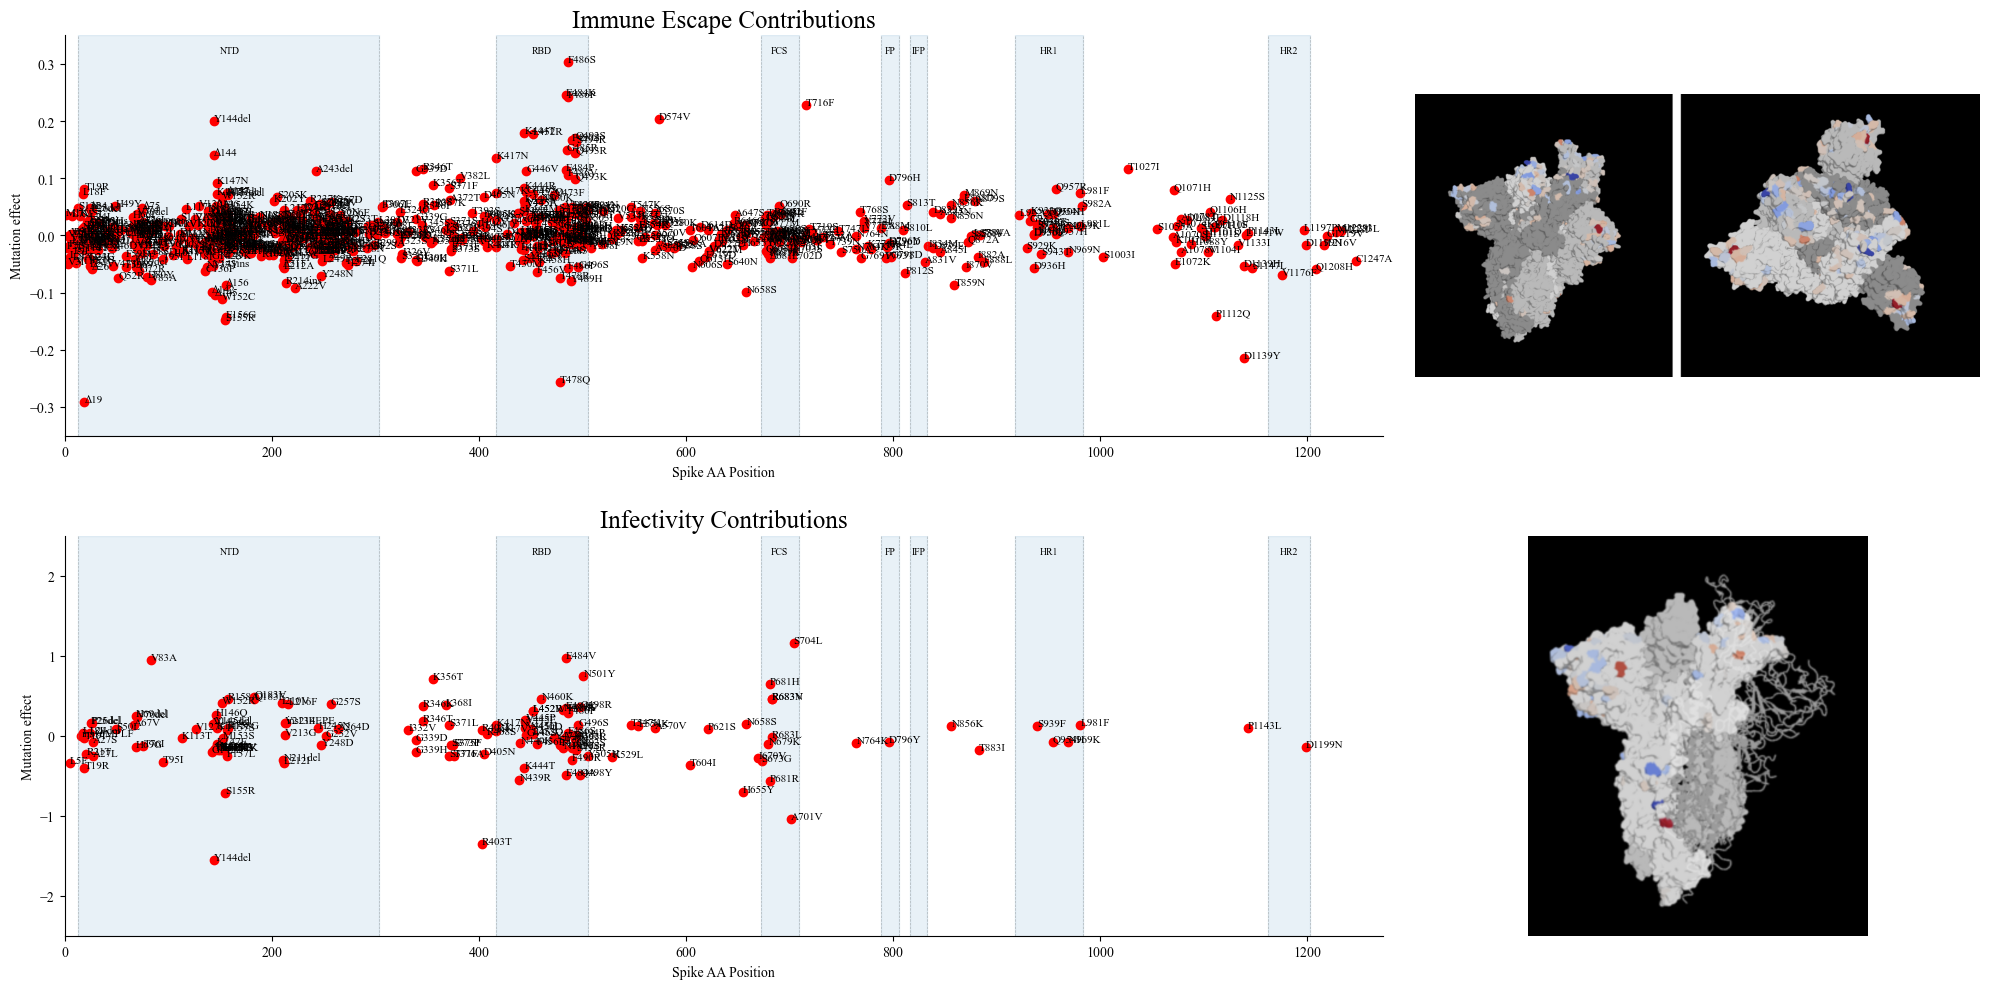

In [6]:
fig, axes = plt.subplots(2,2, figsize=(20,10), gridspec_kw={'width_ratios':[7,3]})

ax = axes[0,0]
options = setup(ax, [-0.35, 0.35])
positions, mutations = get_positions(escape_data['features'])
plot_coef(ax, escape_traces['β'].mean(dim=0), positions, mutations, options)
plot_regions(ax, options)
ax.set_title('Immune Escape Contributions', fontsize=18);
ax.spines[['top', 'right']].set_visible(False);

ax = axes[0,1]
img = mpimg.imread('figs/escape_struct_temp.png')
ax.imshow(img)
ax.axis('off');

ax = axes[1,0]
options = setup(ax, [-2.5, 2.5])
positions, mutations = get_positions(inf_data['features'])
plot_coef(ax, inf_traces['m'].mean(dim=0), positions, mutations, options)
plot_regions(ax, options)
ax.set_title('Infectivity Contributions', fontsize=18);
ax.spines[['top', 'right']].set_visible(False);

ax = axes[1,1]
img = mpimg.imread('figs/infectivity_struct_temp.png')
ax.imshow(img)
ax.axis('off');

fig.tight_layout();
fig.subplots_adjust(hspace=0.25);
# fig.savefig(f'figs/covdb/Manhattan_{date}.png', dpi=150)

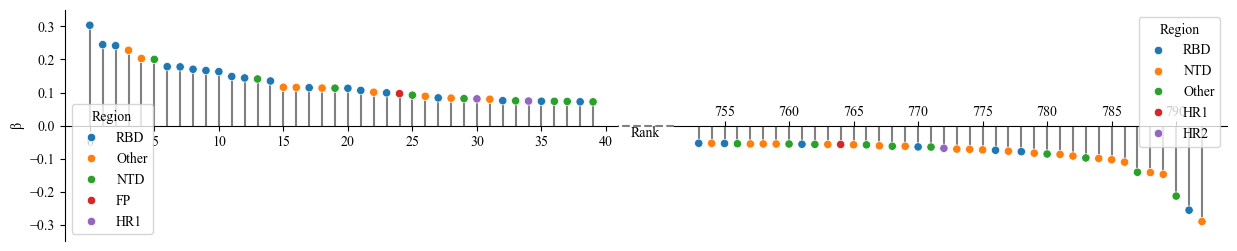

In [7]:
###### ALT FIGURE 1
def get_region(position):
    regions = {'NTD':[13,304],
               'RBD':[417,505],
               # '':[438, 508], # RBM
               'FCS':[672,709],
               'FP':[788, 806],
               'IFP':[816, 833],
               'HR1':[918,983],
               'HR2':[1162,1203]}
    for r, v in regions.items():
        if position >= v[0] and position <= v[1]:
            return r
    return 'Other'
escape_df = pd.DataFrame()
positions, mutations = get_positions(escape_data['features'])
escape_df['Mutation'] = mutations
escape_df['Position'] = positions
escape_df['β'] = escape_traces['β'].mean(dim=0)
escape_df['Region'] = escape_df['Position'].apply(lambda x: get_region(x))
escape_df = escape_df.sort_values(by='β', ascending=False).reset_index(drop=True)
escape_df['Rank'] = escape_df.index
top_n = 40

fig, axes = plt.subplots(1, 3, figsize=(15, 3), gridspec_kw={'width_ratios':[10,1,10]})
fig.subplots_adjust(wspace=0)
ylim = [-0.35, 0.35]

# Top n
ax = axes[0]
color_palette = dict({r:c for r, c in zip(['NTD','RBD','FCS','FP','IFP','HR1','HR2','Other'], sns.color_palette('Set1', 8))})
# for idx, row in escape_df.head(top_n).iterrows():
#     ax.stem(idx, row['β'], markerfacecolor=color_palette[row['Region']])
sns.scatterplot(x='Rank',
                y='β',
                hue='Region',
                data=escape_df.head(top_n),
                ax=ax)
ax.vlines([i for i in range(top_n)], 0, escape_df.head(top_n)['β'], color='gray', zorder=-1);
ax.spines['bottom'].set_position('zero');
ax.spines[['top', 'right']].set_visible(False);
ax.set_ylim(ylim);
ax.set_xlabel('');

# Bottom n
ax = axes[-1]
sns.scatterplot(x='Rank',
                y='β',
                hue='Region',
                data=escape_df.tail(top_n),
                ax=ax)
ax.vlines([len(escape_df) - top_n + i for i in range(top_n)], 0, escape_df.tail(top_n)['β'], color='gray', zorder=-1);
ax.spines['bottom'].set_position('zero');
ax.spines[['top', 'left', 'right']].set_visible(False);
ax.set_yticks([]); ax.set_ylabel('');
ax.set_ylim(ylim);
ax.tick_params(axis="x",direction="in", pad=-15)
ax.set_xlabel('');

# Middle gap
ax = axes[1]
xlim = [0, 1]
ax.hlines(xlim[0], xlim[1], 0, linestyle='--', color='gray')
ax.set_ylim(ylim); ax.set_xlim(xlim);
ax.text(np.mean(xlim), np.mean(ylim), 'Rank', ha='center', va='top');
ax.set_xlim(xlim);
ax.set_ylim(ylim);
ax.axis('off');

In [8]:
def lollipop(df1, ax, orientation='horizontal', space_func=None, labels=False, top_n=300, color_palette='Dark2', ms=8, fs=8):
    # Copy df
    df = df1.copy()
    
    # Calculate x positions
    if not space_func:
        def space_func(x):
            def degree_func(d, x_init:np.array):
                x = np.zeros(x_init.shape)
                for i in range(d):
                    deg = 2*i + 1
                    x += 10**(deg-1)*x_init**deg
                return x
            return degree_func(4, x)
    df = df.sort_values(by='β', ascending=False).reset_index(drop=True)
    df['Rank'] = df.index
    df['x_ctr'] = df['Rank'].apply(lambda x: x/len(df)-1/2)
    df['x'] = space_func(df['x_ctr'].values)
    
    # Create color palette
    if not isinstance(color_palette, dict):
        regions = df['Region'].unique()
        color_palette = dict({r:c for r, c in zip(regions, sns.color_palette(color_palette, len(regions)))})
    
    # Set correct orientation
    if orientation == 'horizontal':
        x='x'
        y='β'
        stem = ax.vlines
        text_offset = [0, 1]
        text_rot = 45
        text_va = ['bottom', 'top']
        text_ha = ['left', 'right']
    elif orientation == 'vertical':
        x='β'
        y='x'
        stem = ax.hlines
        text_offset = [1, 0]
        text_rot = 0
        text_va = ['center', 'center']
        text_ha = ['left', 'right']
    else:
        raise ValueError('orientation must be set to horizontal or vertical')
    
    # Plot dots
    df['markersize'] = np.abs(df['x']); df['markersize'] = df['markersize'] * (ms / df['markersize'].max())
        
    sns.scatterplot(x=x,
                    y=y,
                    data=df,
                    hue='Region',
                    size='markersize',
                    palette=color_palette,
                    ax=ax)
    # Plot poles
    for _, row in df.iterrows():
        stem(row['x'], 0, row['β'], color=color_palette[row['Region']], zorder=-1);
        
    # Add labels
    if labels:
        df['fontsize'] = df['markersize']; df['fontsize'] = df['fontsize'] * (fs / df['fontsize'].max())
        text_buffer = 0.015
        for _, row in df.head(top_n).iterrows():
            ax.text(row[x] + text_buffer*text_offset[0], 
                    row[y] + text_buffer*text_offset[1], 
                    row['Mutation'], 
                    ha=text_ha[0], va=text_va[0], rotation=text_rot, fontsize=row['fontsize'])
        for _, row in df.tail(top_n).iterrows():
            ax.text(row[x] - text_buffer*text_offset[0], 
                    row[y] - text_buffer*text_offset[1], 
                    row['Mutation'], 
                    ha=text_ha[1], va=text_va[1], rotation=text_rot, fontsize=row['fontsize'])

    # Format axis
    if orientation == 'horizontal':
        ax.spines[['bottom']].set_position('zero');
        ax.spines[['top', 'right']].set_visible(False);
        ax.legend().set_visible(False);
    elif orientation == 'vertical':
        ax.spines[['left']].set_position('zero');
        ax.spines[['top', 'right']].set_visible(False);
        ylim = ax.get_ylim(); ax.set_ylim(ylim[1], ylim[0]);
        ax.legend().set_visible(False);
    
    return df, color_palette
    
def plot_normalized_stacked_kde(df, ax, by='β', color_palette='Dark2', orientation='horizontal', bandwidth=0.3, gridsize=200, ylim=None):
    kde_dict = {}
    kde_weight = {}
    
    # Create color palette
    if not isinstance(color_palette, dict):
        regions = df['Region'].unique()
        color_palette = dict({r:c for r, c in zip(regions, sns.color_palette(color_palette, len(regions)))})
    else:
        regions = list(color_palette.keys())
    

    # Define grid over range
    grid_min, grid_max = df[by].min(), df[by].max()
    grid = np.linspace(grid_min, grid_max, gridsize)

    # Compute KDE for each region
    for region in regions:
        data = df[df['Region'] == region][by].values
        if len(data) > 1:
            kde = gaussian_kde(data, bw_method=bandwidth)
            kde_vals = kde(grid)
        else:
            kde_vals = np.zeros_like(grid)
        kde_dict[region] = kde_vals
        kde_weight[region] = len(data)

    # Stack and normalize
    stacked_vals = np.vstack([kde_dict[region]*kde_weight[region] for region in regions])
    normed_stacked_vals = stacked_vals / stacked_vals.sum(axis=0)

    # Plot 
    bottoms = np.zeros_like(grid)
    for region in regions:
        vals = normed_stacked_vals[regions.index(region)]
        if orientation == 'horizontal':
            ax.fill_betweenx(grid, bottoms, bottoms + vals,
                             color=color_palette.get(region, 'gray'),
                             label=region, linewidth=0.5, alpha=0.9)
            bottoms += vals
        elif orientation == 'vertical':
            ax.fill_between(grid, bottoms, bottoms + vals, 
                            color=color_palette.get(region, 'gray'),
                            label=region, linewidth=0.5, alpha=0.9)
            bottoms += vals
        
    # Format axes
    if orientation == 'horizontal':
        ax.set_ylabel(by)
        ax.set_xlabel('Normalized Density')
        ax.set_xticks([]);
    elif orientation == 'vertical':
        ax.set_xlabel(by)
        ax.set_ylabel('Normalized Density')
        ax.set_yticks([]);
    
    # ax.set_title('Normalized Stacked KDE by Region')
    ax.spines[['top', 'right']].set_visible(False);
    ax.legend().set_visible(False);

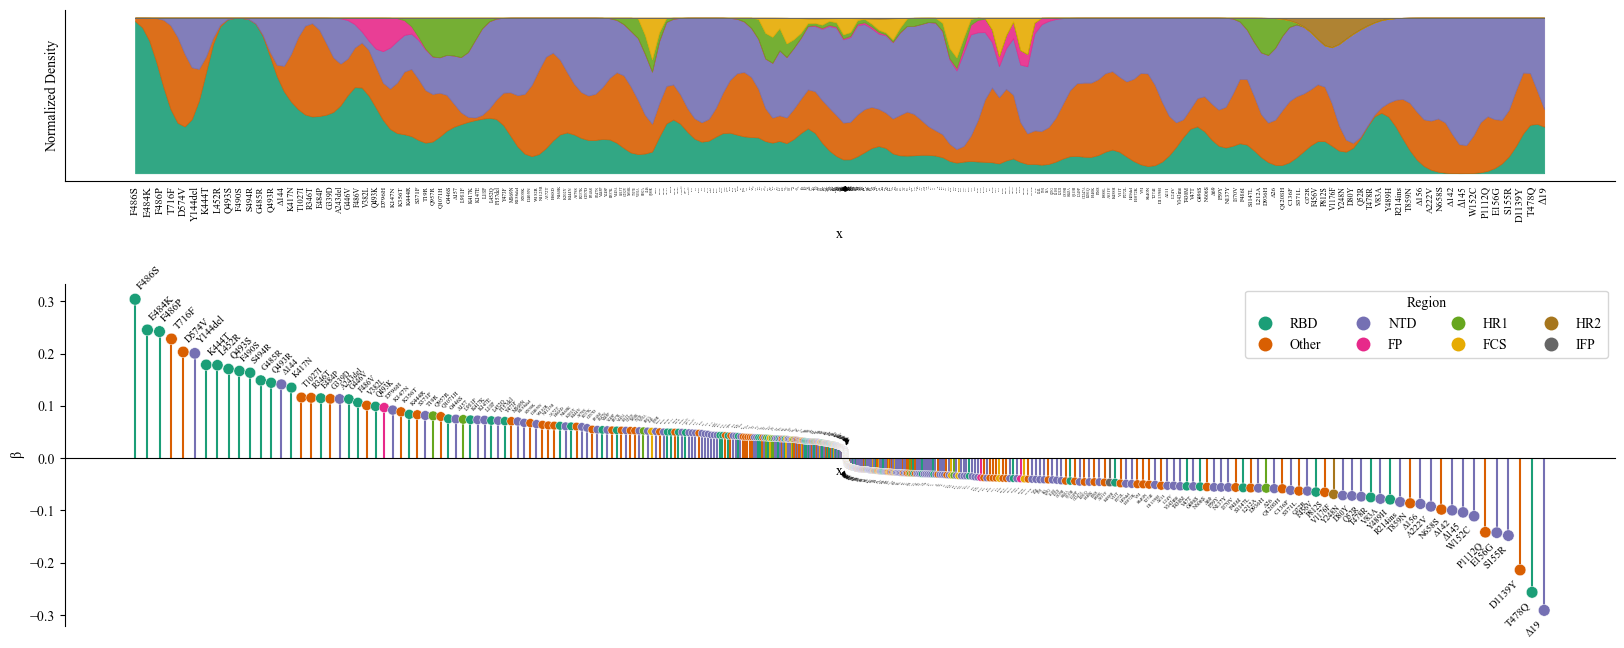

In [9]:
escape_df = pd.DataFrame()
positions, mutations = get_positions(escape_data['features'])
escape_df['Mutation'] = mutations
escape_df['Position'] = positions
escape_df['β'] = escape_traces['β'].mean(dim=0)
escape_df['Region'] = escape_df['Position'].apply(lambda x: get_region(x))

fig, axes = plt.subplots(2, 1, figsize=(20, 8), gridspec_kw={'height_ratios':[1, 2]})

ax = axes[1]
escape_df, palette = lollipop(escape_df, ax, labels=True)
ax.set_xticks([]);
legend_handles = [
    Line2D([0], [0], marker='o', color='none', markeredgecolor='none', markerfacecolor=color, markersize=10, label=label)
    for label, color in palette.items()
]
ax.legend(handles=legend_handles, title='Region', loc='upper right', ncol=len(legend_handles)//2)

ax = axes[0]
plot_normalized_stacked_kde(escape_df, ax, by='x', color_palette=palette, orientation='vertical', bandwidth=0.075, gridsize=200, ylim=None)
ax.set_xticks(escape_df['x']); ax.tick_params(axis='x', which='both', length=0);
ax.set_xticklabels(escape_df['Mutation'], rotation=90);
for label, size in zip(ax.get_xticklabels(), escape_df['fontsize']):
    label.set_fontsize(size)
    
fig.subplots_adjust(hspace=0.4);

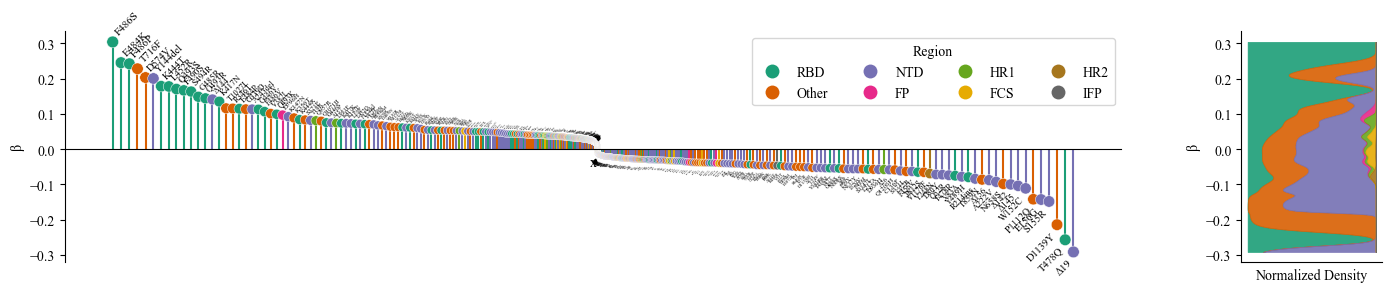

In [10]:
escape_df = pd.DataFrame()
positions, mutations = get_positions(escape_data['features'])
escape_df['Mutation'] = mutations
escape_df['Position'] = positions
escape_df['β'] = escape_traces['β'].mean(dim=0)
escape_df['Region'] = escape_df['Position'].apply(lambda x: get_region(x))

fig, axes = plt.subplots(1, 2, figsize=(17, 3), gridspec_kw={'width_ratios':[15, 2]})

ax = axes[0]
escape_df, palette = lollipop(escape_df, ax, labels=True)
ax.set_xticks([]);
legend_handles = [
    Line2D([0], [0], marker='o', color='none', markeredgecolor='none', markerfacecolor=color, markersize=10, label=label)
    for label, color in palette.items()
]
ax.legend(handles=legend_handles, title='Region', loc='upper right', ncol=len(legend_handles)//2)

ax = axes[1]
plot_normalized_stacked_kde(escape_df, ax, by='β', color_palette=palette, orientation='horizontal', bandwidth=0.3, gridsize=200, ylim=None)

In [11]:
# Should also try looking at log(P). Can look at log(P) by position, log(P) by region, and kdeplot of log(P)

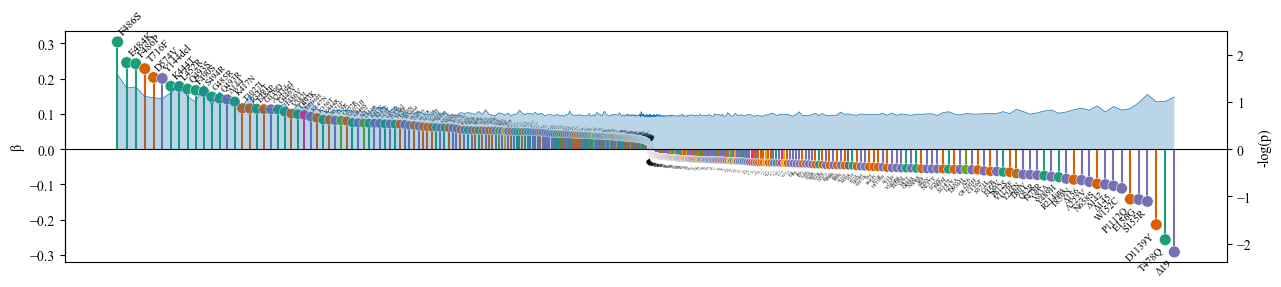

In [12]:
p_df = pd.DataFrame()
p_df['Mutation'] = escape_data['features']
p_df['p'] = (escape_traces['β'] > 0).sum(axis=0) / escape_traces['β'].shape[0]
p_df['one sided p'] = p_df['p'].apply(lambda p: min(p, 1-p))
p_df['-log(p)'] = p_df['one sided p'].apply(lambda p: -np.log(p))
p_df = pd.merge(escape_df, p_df, on='Mutation')
p_df

fig, ax = plt.subplots(figsize=(15, 3))
p_df, palette = lollipop(p_df, ax, labels=True)
ax.set_xticks([]); ax.set_xlabel('');
ax2 = ax.twinx()
ax2.fill_between(p_df['x'], 0, p_df['-log(p)'], alpha=0.3, zorder=-1)
sns.lineplot(x='x',
             y='-log(p)',
             data=p_df,
             linewidth=0.5,
             ax=ax2);
ax2.hlines(-np.log(0.05), p_df['x'].min(), p_df['x'].max(), linestyle='--', linewidth=0.5, color='gray');
ax2.set_ylim([-2.4, 2.5]);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


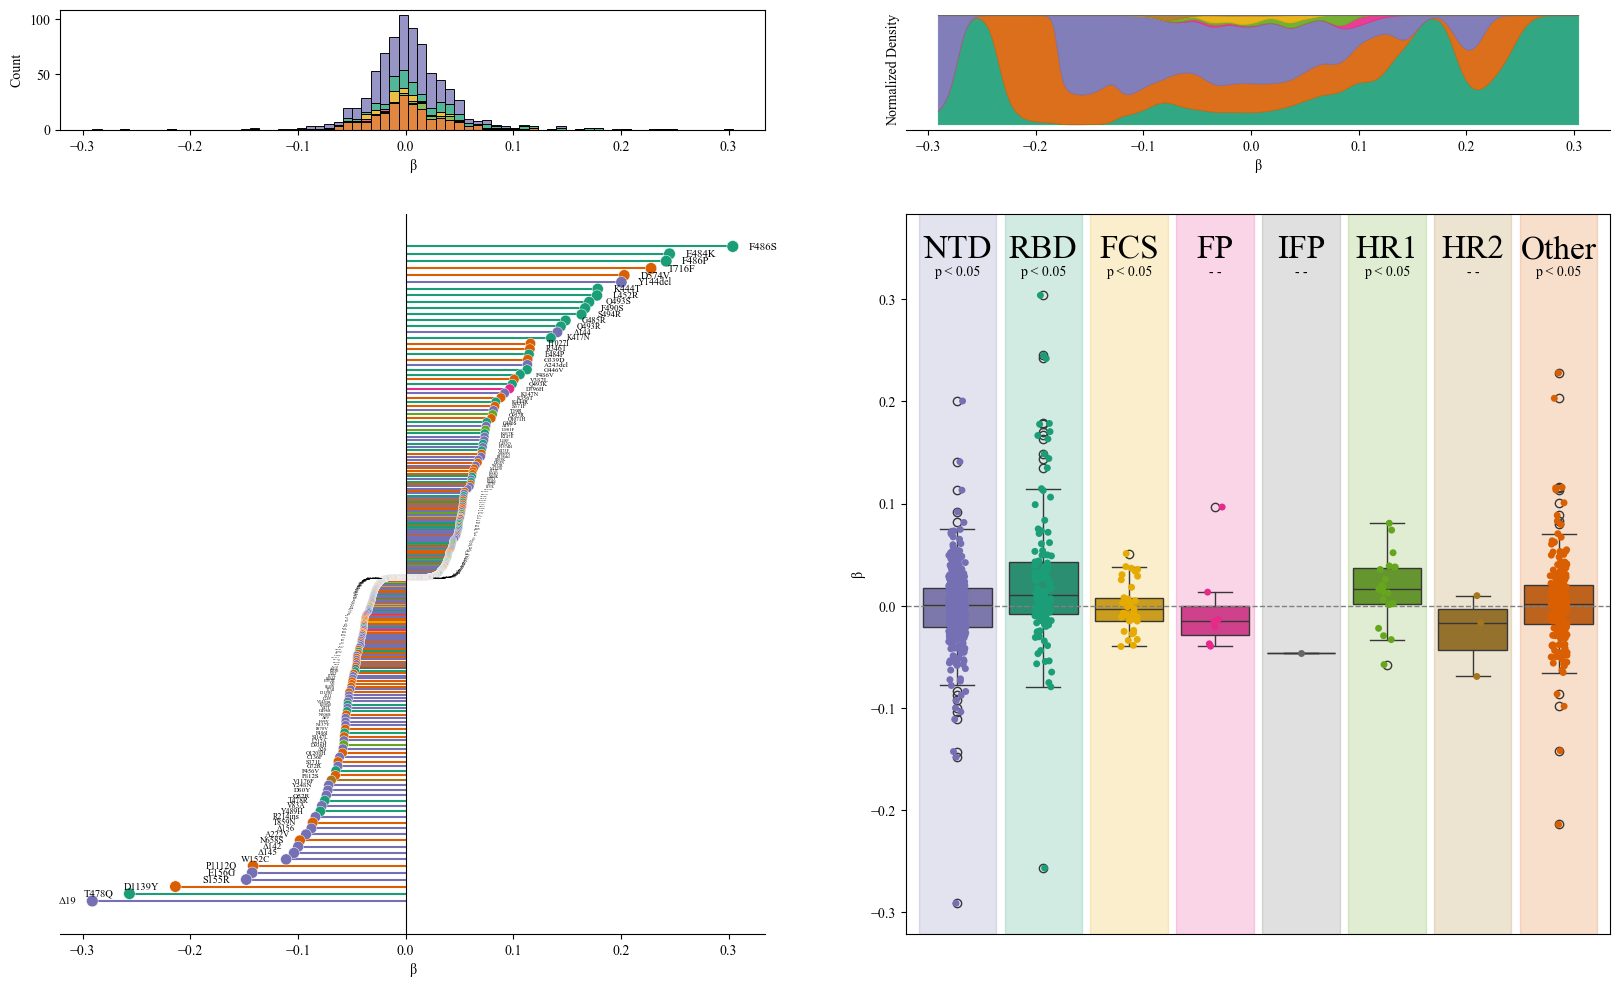

In [13]:
def space_func(x):
    a = 3
    b = 1
    c = 0
    d = 0
    e = 0
    return (a*x)**9 + (b*x)**7 + (c*x)**5 + (d*x)**3 + (e*x)

fig, axes = plt.subplots(2, 2, figsize=(20, 12), gridspec_kw={'height_ratios':[1, 6]})

ax = axes[1, 0]
escape_df, palette = lollipop(escape_df, ax, labels=True, space_func=space_func, orientation='vertical')
ax.set_yticks([]); ax.set_ylabel('');

ax = axes[1, 1]
region_order = ['NTD', 'RBD', 'FCS', 'FP', 'IFP', 'HR1', 'HR2', 'Other']
sns.boxplot(y='β',
            x='Region',
            hue='Region',
            data=escape_df,
            palette=palette,
            # showfliers=True,
            order=region_order,
            ax=ax);
sns.stripplot(y='β',
            x='Region',
            hue='Region',
            data=escape_df,
            palette=palette,
            jitter=True,
            order=region_order,
            ax=ax);
ylim = ax.get_ylim()
for i, reg in enumerate(region_order):
    data = escape_df[escape_df['Region']==reg]['β'].values
    D, p_val = kstest(data, 'laplace', (0, sb)) 
    label = 'p < 0.05' if p_val<0.05 else '- -'
    ax.text(i, ylim[1], reg, fontsize=24, ha='center', va='bottom')
    ax.text(i, ylim[1], label, fontsize=10, ha='center', va='top')
    ax.fill_between([i-0.45, i+0.45], [ylim[0], ylim[0]], [1.2*ylim[1], 1.2*ylim[1]], color=palette[reg], alpha=0.2, zorder=-1)
ax.set_ylim([ylim[0], 1.15*ylim[1]]);
ax.set_xlim([-0.6, len(region_order)-1+0.6]);
ax.set_xticks([]);
ax.set_xlabel('');
    
xlim = ax.get_xlim()
ax.hlines(0, xlim[0], xlim[1], color='gray', linestyle='--', linewidth=1);
ax.set_xlim(xlim);

ax = axes[0,0]
sns.histplot(x='β',
             hue='Region',
             data=escape_df,
             multiple='stack',
             hue_order=['NTD', 'RBD', 'FCS', 'FP', 'IFP', 'HR1', 'HR2', 'Other'],
             palette=palette,
             ax=ax);
# ax.set_yscale('log');
ax.legend().set_visible(False);

ax = axes[0, 1]
plot_normalized_stacked_kde(escape_df, ax, by='β', color_palette=palette, orientation='vertical', bandwidth=0.3, gridsize=200, ylim=None)
ax.spines[['left']].set_visible(False);

/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53072/420310604.py:20: RuntimeWarning: invalid value encountered in divide
  dat = stacked_hist.loc[reg][0][0] / stacked_hist_sums


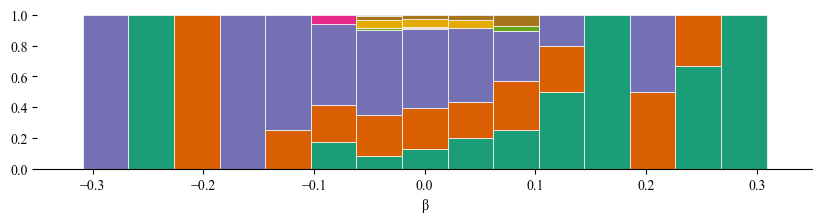

In [302]:
region_palette = dict({r:c for r,c in zip(['RBD', 'Other', 'NTD', 'HR2', 'FP', 'FCS', 'HR1', 'IFP'], sns.color_palette('Dark2'))})

# sym_bins = np.logspace(-8, -0.5, 20, base=2)
hist_bins = np.linspace(-.35, .35, 18)
# hist_bins = np.append(         # np.linspace(-0.35, 0.35, 80)   # sorted(np.append(-sym_bins, sym_bins))
#             np.append(np.linspace(-0.4, -0.1, 6),  
#                       np.linspace(-0.1, 0.1, 20)),
#                       np.linspace(0.1, 0.4, 6))
stacked_hist = escape_df[['Region', 'β']].groupby('Region').agg(lambda series: [np.histogram(series, bins=hist_bins)[0]])
stacked_hist_regions = stacked_hist.index.tolist()
stacked_hist_rawvals = np.stack(stacked_hist.values.tolist()).squeeze()
stacked_hist_sums = stacked_hist_rawvals.sum(axis=0)
# stacked_hist_norm = stacked_hist_rawvals / stacked_hist_sums

fig, ax = plt.subplots(figsize=(10, 2))

bin_bottoms = np.zeros_like(hist_bins[:-1])
# for reg, dat in zip(stacked_hist_regions, stacked_hist_norm):
for reg in ['RBD', 'Other', 'NTD', 'HR2', 'FP', 'FCS', 'HR1', 'IFP']:
    dat = stacked_hist.loc[reg][0][0] / stacked_hist_sums
    color = region_palette[reg]
    bin_tops = bin_bottoms + np.nan_to_num(dat, 0)
    for (x_min, x_max), y_min, y_max in zip(zip(hist_bins[:-1], hist_bins[1:]), bin_bottoms, bin_tops):
        if not y_min == y_max:
            ax.fill_between([x_min, x_max], [y_min, y_min], [y_max, y_max], 
                            color=color, edgecolor='white', linewidth=0.5)
    bin_bottoms = bin_tops
    
ax.set_xlabel('β');
# ax.set_ylabel('Proportion of mutations');
ax.spines[['left', 'top', 'right']].set_visible(False);
ax.set_ylim([0, 1]);
ax.set_xlim([hist_bins[0], hist_bins[-1]]);

fig.savefig('figs/ALTERNATE_FIGURE_1/normalized_hist.png', dpi=200);

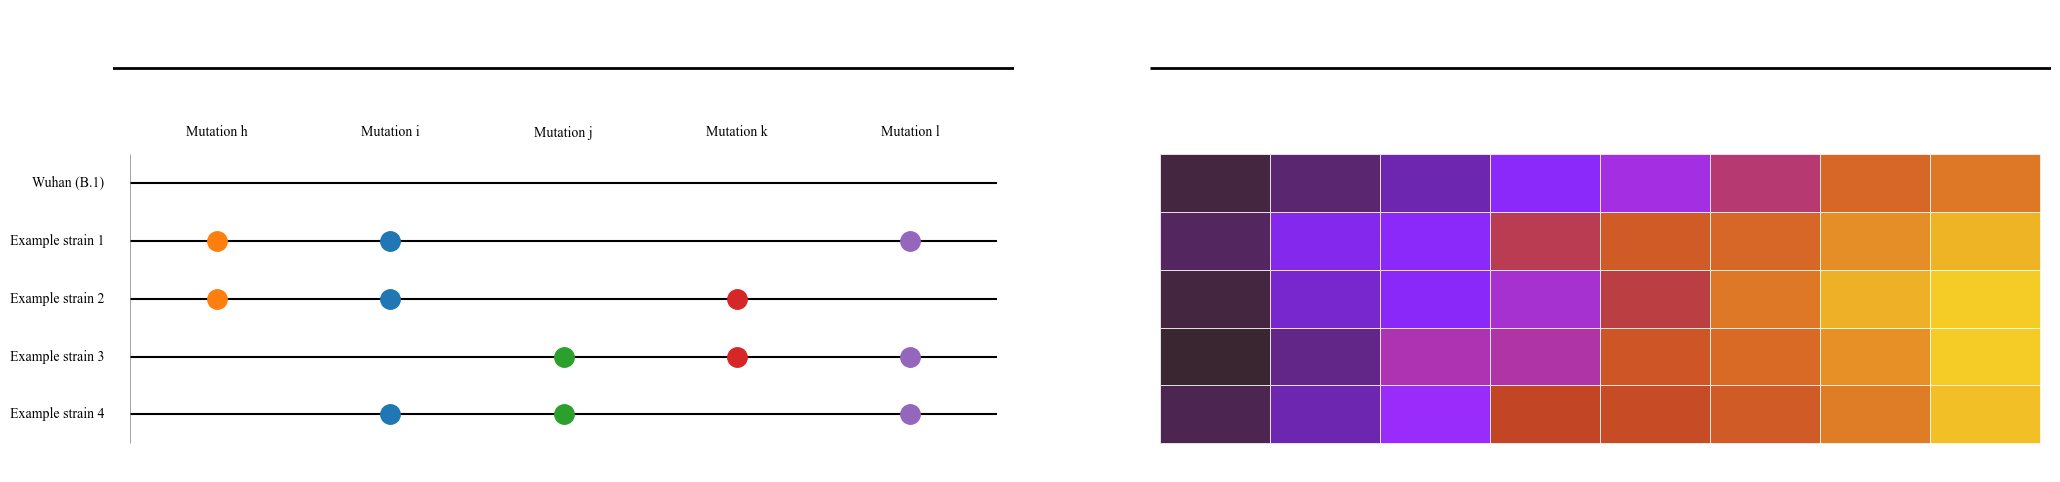

In [14]:
###################################################################################
##### ROW 1: EXAMPLE STRAINS
###################################################################################
fig, axes = plt.subplots(1, 2, figsize=(25, 6));
fig.subplots_adjust(wspace=0.15)
ms = 8
fs = 12
head=2

# Strains
ax = axes[0]
mut_positions = np.array(list(range(5)))
mut_colors = np.array(['tab:orange', 'tab:blue', 'tab:green', 'tab:red', 'tab:purple'])
mut_letters = ['h', 'i', 'j', 'k', 'l']
strainA = np.array([1, 1, 0, 0, 1])
strainB = np.array([1, 1, 0, 1, 0])
strainC = np.array([0, 0, 1, 1, 1])
strainD = np.array([0, 1, 1, 0, 1])
strains = [strainA, strainB, strainC, strainD]
# Plot mutations
for i, strain in enumerate(reversed(strains)):
    ax.hlines(i, -0.5, len(mut_positions)-0.5, color='black');
    ax.text(-0.65, i, f"Example strain {len(strains)-i}", ha='right', va='center', clip_on=False);
    # ax.plot([0.05, 0.95], [1-0.2*(i+1)]*2, marker='o', markersize=3, linestyle='', color='tab:blue');
    for mut, color in zip(mut_positions[strain.nonzero()], mut_colors[strain.nonzero()]):
        ax.plot(mut, i, marker='o', color=color, markersize=1.75*ms)
    # ax.plot(mut_positions[strain.nonzero()], [i]*strain.sum(), linestyle='', 
    #         marker='o', color='tab:blue', markerfacecolor='white', markersize=1.2*ms)
# Plot WT
ax.hlines(len(strains), -0.5, len(mut_positions)-0.5, color='black');
ax.text(-0.65, len(strains), f"Wuhan (B.1)", ha='right', va='center', clip_on=False);
# Label mutations
for x in range(5):
    ax.text(x, len(strains)+1, f'Mutation {mut_letters[x]}', va='top', ha='center');
ax.vlines(-0.5, -0.5, len(strains)+0.5, linewidth=0.5, color='gray')
ax.set_xlim([-0.6, len(mut_positions)-0.5]);
ax.set_ylim([-1, len(strains)+1+head]);
ax.axis('off');
xlim = ax.get_xlim();
ax.hlines(len(strains)+1+head-1, xlim[0]-0.1, xlim[1]+0.1, linewidth=2, color='black');
ax.set_xlim([-0.6, len(mut_positions)-0.4]);


# Immune escape
ax = axes[1]
data = np.array([[0.82, 0.85,0.90,1.00,1.10,1.20,1.40,1.45],
                 [0.84, 0.97,1.00,1.22,1.36,1.40,1.50,1.58],
                 [0.82, 0.93,0.99,1.12,1.23,1.45,1.57,1.62],
                 [0.81, 0.87,1.15,1.16,1.34,1.41,1.51,1.62],
                 [0.83, 0.90,1.05,1.27,1.30,1.36,1.46,1.60]])[::-1]
ie_example_df = pd.DataFrame(columns=['No previous exposure', 'Alpha', 'B.1', 'BA.1', 'B.2.12.1', 'Beta', 'Delta', 'Omicron BA.4/5'], 
                             index=['Wuhan (B.1)'] + [f"Example strain {i}" for i in range(len(strains))],
                             data=data)
sns.heatmap(ie_example_df, 
            cmap='gnuplot',
            vmin=0.8,
            vmax=1.7,
            cbar=False,
            alpha=0.85,
            linewidths=0.5,
            ax=ax);
ax.set_xticks([]); ax.set_yticks([]); 
ax.set_ylim([-0.5, len(strains)+1.5+head]);
xlim = ax.get_xlim();
ax.hlines(len(strains)+1.5+head-1, xlim[0]-0.1, xlim[1]+0.1, linewidth=2, color='black');
ax.set_xlim([xlim[0]-0.1, xlim[1]+0.1]);


fig.savefig('figs/ALTERNATE_FIGURE_1/example_strains.png', dpi=200)

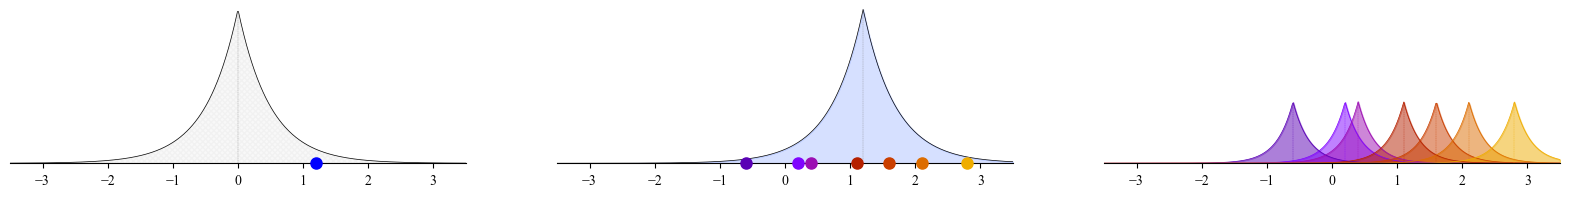

In [15]:
###################################################################################
##### ROW 2: PRIORS
###################################################################################
fig, axes = plt.subplots(1, 3, figsize=(20, 2));

### For axes showing distributions / all axes on the left:
xlim = [-3.5, 3.5]
ylim = [0, 1]
dist_axes = []
### For pool-specific effects:
varns = ['B.1', 'Omicron BA.4/5', 'BA.2.12.1', 'Delta', 'Beta', 'Alpha', 'BA.1']
pool_colors = {p:c for p, c in zip(varns,
                                   sns.color_palette('gnuplot', len(varns)))}

###### PRIOR
ax = axes[0]
dist_axes.append(ax)
x = np.linspace(xlim[0], xlim[1], 500)
μ = 0; b = 0.5
y = laplace(μ, b).pdf(x)
ax.plot(x, y, color='k', linewidth=0.5)
ax.fill_between(x, y, color='gray', alpha=0.05, hatch='xxxxxx')
ax.vlines(μ, 0, np.max(y), color='gray', linewidth=0.25, linestyle='--')
βj = 1.2
ax.plot(βj, 0, marker='o', markersize=ms, color='blue', clip_on=False, zorder=100);


###### POOL-AGNOSTIC
ax = axes[1]
dist_axes.append(ax)
yj = laplace(βj, b).pdf(x)
ax.plot(x, yj, color='k', linewidth=0.5)
ax.fill_between(x, yj, color=(0.2, 0.4, 1), alpha=0.2)
ax.vlines(βj, 0, np.max(yj), color='gray', linewidth=0.25, linestyle='--')
βji = [-0.6, 0.2, 0.4, 1.1, 1.6, 2.1, 2.8]
for i, v in enumerate(varns):
    ax.plot(βji[i], 0, marker='o', markersize=ms, color=pool_colors[v], clip_on=False, zorder=100);



###### POOL-SPECIFIC
ax = axes[2]
dist_axes.append(ax)
for i, v in enumerate(varns):
    yji = laplace(βji[i], b/2).pdf(x)/5
    ax.plot(x, yji, color=pool_colors[v], linewidth=0.5)
    ax.fill_between(x, yji, color=pool_colors[v], alpha=0.5)
    ax.vlines(βji[i], 0, np.max(yji), color=pool_colors[v], linewidth=0.25, linestyle='--')
    



##### Adjust all mut dist axes
for ax in dist_axes:
    ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_yticks([]);
    ax.spines[['left', 'right', 'top']].set_visible(False);

fig.savefig('figs/ALTERNATE_FIGURE_1/distributions.png', dpi=200)

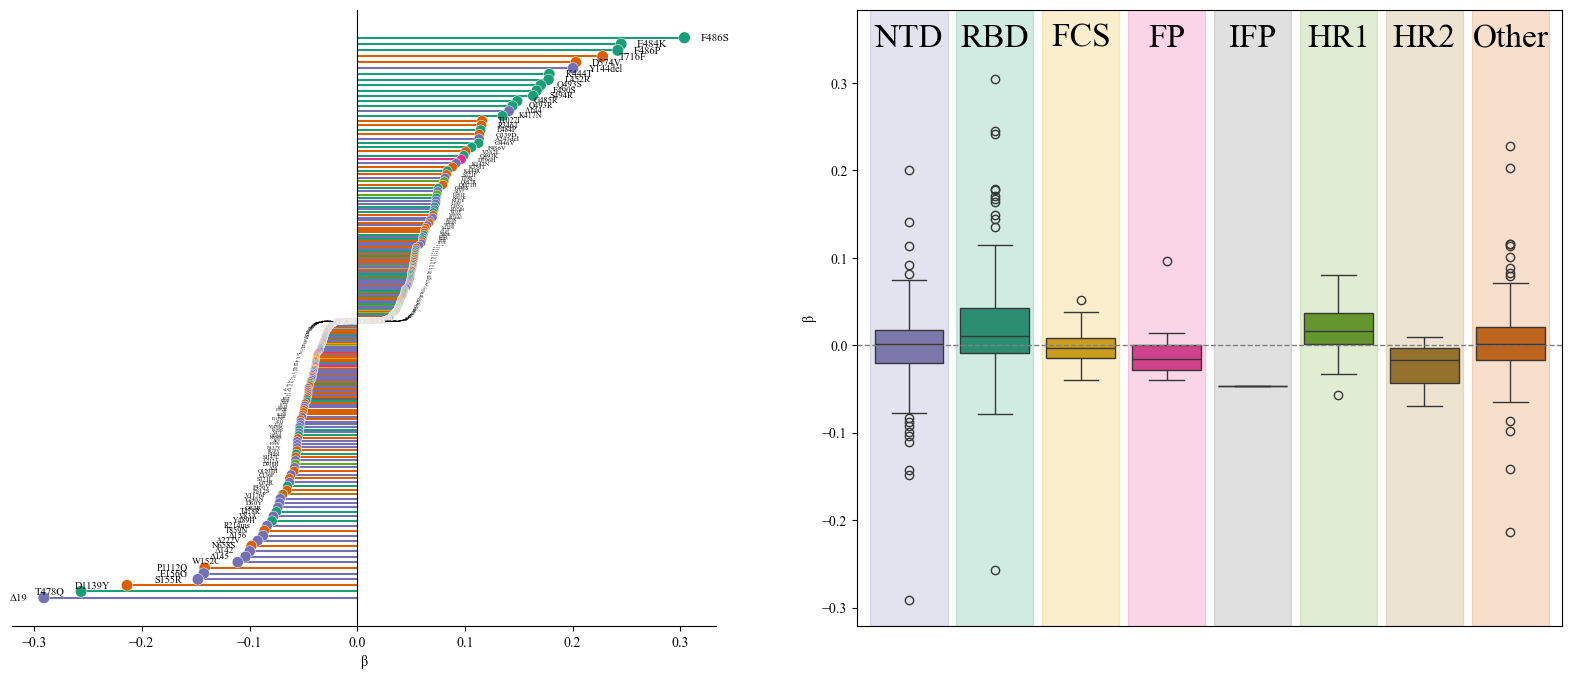

In [16]:
###################################################################################
##### ROW 3: RESULTS
###################################################################################
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

###### LOLLIPOP PLOT
ax = axes[0]
# ax.set_title('Mutation Immune Escape (Pool Agnostic)', fontsize=fs*1.5)
def space_func(x):
    a = 3
    b = 1
    c = 0
    d = 0
    e = 0
    return (a*x)**9 + (b*x)**7 + (c*x)**5 + (d*x)**3 + (e*x)
escape_df, palette = lollipop(escape_df, ax, labels=True, space_func=space_func, orientation='vertical')
ax.set_yticks([]); ax.set_ylabel('');



###### BOXPLOTS
ax = axes[1]
# ax.set_title('Immune Escape by Spike Region', fontsize=fs*1.5)
region_order = ['NTD', 'RBD', 'FCS', 'FP', 'IFP', 'HR1', 'HR2', 'Other']
sns.boxplot(y='β',
            x='Region',
            hue='Region',
            data=escape_df,
            palette=palette,
            showfliers=True,
            order=region_order,
            ax=ax);
ylim = ax.get_ylim()
for i, reg in enumerate(region_order):
    data = escape_df[escape_df['Region']==reg]['β'].values
    D, p_val = kstest(data, 'laplace', (0, sb)) 
    label = 'p < 0.05' if p_val<0.05 else '- -'
    ax.text(i, ylim[1], reg, fontsize=24, ha='center', va='bottom')
    # ax.text(i, ylim[1], label, fontsize=10, ha='center', va='top')
    ax.fill_between([i-0.45, i+0.45], [ylim[0], ylim[0]], [1.2*ylim[1], 1.2*ylim[1]], color=palette[reg], alpha=0.2, zorder=-1)
ax.set_ylim([ylim[0], 1.15*ylim[1]]);
ax.set_xlim([-0.6, len(region_order)-1+0.6]);
ax.set_xticks([]);
ax.set_xlabel('');
    
xlim = ax.get_xlim()
ax.hlines(0, xlim[0], xlim[1], color='gray', linestyle='--', linewidth=1);
ax.set_xlim(xlim);

fig.savefig('figs/ALTERNATE_FIGURE_1/results.png', dpi=300)

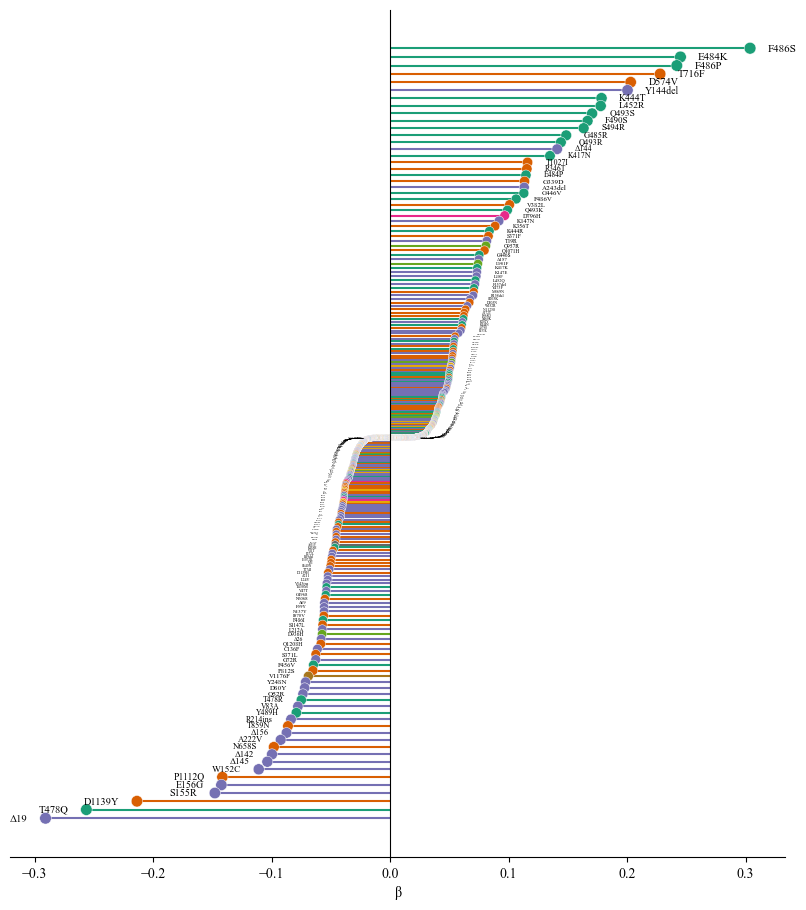

In [17]:
###################################################################################
##### ROW 3: RESULTS
###################################################################################
fig, ax = plt.subplots(1, 1, figsize=(10, 11))

###### LOLLIPOP PLOT
# ax.set_title('Mutation Immune Escape (Pool Agnostic)', fontsize=fs*1.5)
def space_func(x):
    a = 3
    b = 1
    c = 0
    d = 0
    e = 0
    return (a*x)**9 + (b*x)**7 + (c*x)**5 + (d*x)**3 + (e*x)
escape_df, palette = lollipop(escape_df, ax, labels=True, space_func=space_func, orientation='vertical')
ax.set_yticks([]); ax.set_ylabel('');

fig.savefig('figs/ALTERNATE_FIGURE_1/results_a.png', dpi=300)

In [339]:
escape_df.sort_values(by='β', ascending=False).head(10)[escape_df['Region']!='RBD'][['Mutation', 'Position']]

/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53072/152741061.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  escape_df.sort_values(by='β', ascending=False).head(10)[escape_df['Region']!='RBD'][['Mutation', 'Position']]


,Mutation,Position
3,T716F,716
4,D574V,574
5,Y144del,144


In [345]:
escape_df[escape_df['Region']=='Other'].head(5)

,Mutation,Position,β,Region,Rank,x_ctr,x,markersize,fontsize
3,T716F,716,0.227867,Other,3,-0.496217,-0.559314,7.939462,7.939462
4,D574V,574,0.203008,Other,4,-0.494956,-0.557892,7.919282,7.919282
15,T1027I,1027,0.115927,Other,15,-0.481084,-0.542255,7.697309,7.697309
16,R346T,346,0.115367,Other,16,-0.479823,-0.540833,7.677129,7.677129
18,G339D,339,0.113402,Other,18,-0.477301,-0.537990,7.636770,7.636770


In [350]:
region_palette

{'RBD': (0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 'Other': (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 'NTD': (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 'HR2': (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 'FP': (0.4, 0.6509803921568628, 0.11764705882352941),
 'FCS': (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
 'HR1': (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
 'IFP': (0.4, 0.4, 0.4)}

In [378]:
regions = {'NTD':[13,304],
           'RBD':[417,505],
           # '':[438, 508], # RBM
           'FCS':[672,709],
           'FP':[788, 806],
           'IFP':[816, 833],
           'HR1':[918,983],
           'HR2':[1162,1203]}

muts_pml = {
    "F486": {"site":486, "color":'k'},
    "T716": {"site":716, "color":'k'},
    "D574": {"site":574, "color":'k'},
    "Q339": {"site":339, "color":'k'},
    "D1139Y": {"site":1139, "color":'white'},
    "P1112Q": {"site":1112, "color":'white'},
    "T478Q": {"site":478, "color":'white'},
    "658": {"site":658, "color":'white'}
}

ofname= "figs/ALTERNATE_FIGURE_1/structure_escape.pml"
pdb = "7bnn"

with open(ofname, 'w') as of_mean:
    of_mean.write(f"fetch {pdb}\n")
    of_mean.write("remove solvent\n")
    of_mean.write("remove not polymer.protein\n")
    of_mean.write("set specular, 0\n")
    of_mean.write("set depth_cue, 0\n")
    of_mean.write("set ambient, 0.5\n")
    of_mean.write("set ray_trace_gain, 0\n")
    of_mean.write("set ray_trace_mode, 1\n")
    of_mean.write("set ray_trace_color, black\n")
    of_mean.write("set ray_trace_depth_factor, 1\n")
    of_mean.write("set ray_trace_disco_factor, 1\n")
    of_mean.write("set light_count, 2\n")
    of_mean.write("set ray_opaque_background, 0\n")
    
    of_mean.write(f"show cartoon, chain B\n set cartoon_loop_radius, 0.4\n")
    chain_list = " or ".join([f'chain {chain}' for chain in ["A","C"]])
    of_mean.write(f"show as spheres, {chain_list}\n")
    of_mean.write(f"show surface, {chain_list}\n")
    of_mean.write(f"hide cartoon, {chain_list}\n")
    of_mean.write("set transparency, 0.1\n")
    of_mean.write("color gray40, chain C\n")
    of_mean.write("color gray60, chain A\n")
    of_mean.write("color gray80, chain B\n")
    
    
    # of_mean.write("hide surface, chain B\n")
    # for region, (start, end) in regions.items():
    #     rgb = region_palette[region]
    #     of_mean.write(f"set_color {region}_color, [{rgb[0]},{rgb[1]},{rgb[2]}]\n")
    #     of_mean.write(f"show surface, chain B and resi {start}-{end}\n")
    #     of_mean.write(f"set surface_color, {region}_color, chain B and resi {start}-{end}\n")
    #     of_mean.write(f"set transparency, 0.7, chain B and resi {start}-{end}\n")
    
    resi_list = []
    # for mut, d in muts_pml.items():
    #     of_mean.write(f"set_color count_{str(mut)}, {list(colors.to_rgb(d['color']))}\n")
    #     of_mean.write(f"color count_{str(mut)}, chain B and (resi {d['site']})\n")
    #     resi_list.append(f"resi {d['site']}")
    for _, row in escape_df.sort_values(by='β', ascending=False).head(20).iterrows():
        mut = row['Mutation']
        site = row['Position']
        color = region_palette[row['Region']]
        
        of_mean.write(f"set_color count_{str(mut)}, {list(colors.to_rgb(color))}\n")
        of_mean.write(f"color count_{str(mut)}, chain B and (resi {site})\n")
        resi_list.append(f"resi {site}")

    of_mean.write(f"select muts, chain B and ({' or '.join(resi_list)}) and n. CA\n")
    of_mean.write(f"show spheres, muts\n")
    of_mean.write(f"set sphere_scale, 1.3\n")
    of_mean.write("bg 0\n")
    
# subprocess.run(["cd", "/Users/kotzen/Documents/infectivity-neutralization-analysis/"]);
# subprocess.run(["/Applications/PyMOL.app/Contents/MacOS/PyMOL", ofname]);
# import os
# os.system(f"/Applications/PyMOL.app/Contents/MacOS/PyMOL /Users/kotzen/Documents/infectivity-neutralization-analysis/{of_mean}")

In [379]:
regions = {'NTD':[13,304],
           'RBD':[417,505],
           # '':[438, 508], # RBM
           'FCS':[672,709],
           'FP':[788, 806],
           'IFP':[816, 833],
           'HR1':[918,983],
           'HR2':[1162,1203]}

muts_pml = {
    "F486": {"site":486, "color":'k'},
    "T716": {"site":716, "color":'k'},
    "D574": {"site":574, "color":'k'},
    "Q339": {"site":339, "color":'k'},
    "D1139Y": {"site":1139, "color":'white'},
    "P1112Q": {"site":1112, "color":'white'},
    "T478Q": {"site":478, "color":'white'},
    "658": {"site":658, "color":'white'}
}

ofname= "figs/ALTERNATE_FIGURE_1/structure_capture.pml"
pdb = "7bnn"

with open(ofname, 'w') as of_mean:
    of_mean.write(f"fetch {pdb}\n")
    of_mean.write("remove solvent\n")
    of_mean.write("remove not polymer.protein\n")
    of_mean.write("set specular, 0\n")
    of_mean.write("set depth_cue, 0\n")
    of_mean.write("set ambient, 0.5\n")
    of_mean.write("set ray_trace_gain, 0\n")
    of_mean.write("set ray_trace_mode, 1\n")
    of_mean.write("set ray_trace_color, black\n")
    of_mean.write("set ray_trace_depth_factor, 1\n")
    of_mean.write("set ray_trace_disco_factor, 1\n")
    of_mean.write("set light_count, 2\n")
    of_mean.write("set ray_opaque_background, 0\n")
    
    of_mean.write(f"show cartoon, chain B\n set cartoon_loop_radius, 0.4\n")
    chain_list = " or ".join([f'chain {chain}' for chain in ["A","C"]])
    of_mean.write(f"show as spheres, {chain_list}\n")
    of_mean.write(f"show surface, {chain_list}\n")
    of_mean.write(f"hide cartoon, {chain_list}\n")
    of_mean.write("set transparency, 0.1\n")
    of_mean.write("color gray40, chain C\n")
    of_mean.write("color gray60, chain A\n")
    of_mean.write("color gray80, chain B\n")
    
    
    # of_mean.write("hide surface, chain B\n")
    # for region, (start, end) in regions.items():
    #     rgb = region_palette[region]
    #     of_mean.write(f"set_color {region}_color, [{rgb[0]},{rgb[1]},{rgb[2]}]\n")
    #     of_mean.write(f"show surface, chain B and resi {start}-{end}\n")
    #     of_mean.write(f"set surface_color, {region}_color, chain B and resi {start}-{end}\n")
    #     of_mean.write(f"set transparency, 0.7, chain B and resi {start}-{end}\n")
    
    resi_list = []
    # for mut, d in muts_pml.items():
    #     of_mean.write(f"set_color count_{str(mut)}, {list(colors.to_rgb(d['color']))}\n")
    #     of_mean.write(f"color count_{str(mut)}, chain B and (resi {d['site']})\n")
    #     resi_list.append(f"resi {d['site']}")
    for _, row in escape_df.sort_values(by='β', ascending=True).head(20).iterrows():
        mut = row['Mutation']
        site = row['Position']
        color = region_palette[row['Region']]
        
        of_mean.write(f"set_color count_{str(mut)}, {list(colors.to_rgb(color))}\n")
        of_mean.write(f"color count_{str(mut)}, chain B and (resi {site})\n")
        resi_list.append(f"resi {site}")

    of_mean.write(f"select muts, chain B and ({' or '.join(resi_list)}) and n. CA\n")
    of_mean.write(f"show spheres, muts\n")
    of_mean.write(f"set sphere_scale, 1.3\n")
    of_mean.write("bg 0\n")
    
# subprocess.run(["cd", "/Users/kotzen/Documents/infectivity-neutralization-analysis/"]);
# subprocess.run(["/Applications/PyMOL.app/Contents/MacOS/PyMOL", ofname]);
# import os
# os.system(f"/Applications/PyMOL.app/Contents/MacOS/PyMOL /Users/kotzen/Documents/infectivity-neutralization-analysis/{of_mean}")

In [ ]:
escape_df.sort_values(by='β', ascending=True).head(20)#.sort_values(by='Region')

,Mutation,Position,β,Region,Rank,x_ctr,x,markersize,fontsize
792,Δ19,19,-0.291042,NTD,792,0.498739,0.562317,7.982100,7.982100
791,T478Q,478,-0.256561,RBD,791,0.497478,0.560896,7.961920,7.961920
790,D1139Y,1139,-0.213858,Other,790,0.496217,0.559474,7.941741,7.941741
789,S155R,155,-0.148056,NTD,789,0.494956,0.558053,7.921561,7.921561
788,E156G,156,-0.142559,NTD,788,0.493695,0.556631,7.901382,7.901382
787,P1112Q,1112,-0.141738,Other,787,0.492434,0.555209,7.881203,7.881203
786,W152C,152,-0.111033,NTD,786,0.491173,0.553788,7.861023,7.861023
785,Δ145,145,-0.103741,NTD,785,0.489912,0.552366,7.840844,7.840844
784,Δ142,142,-0.099835,NTD,784,0.488651,0.550945,7.820664,7.820664
783,N658S,658,-0.098271,Other,783,0.487390,0.549523,7.800485,7.800485


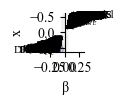

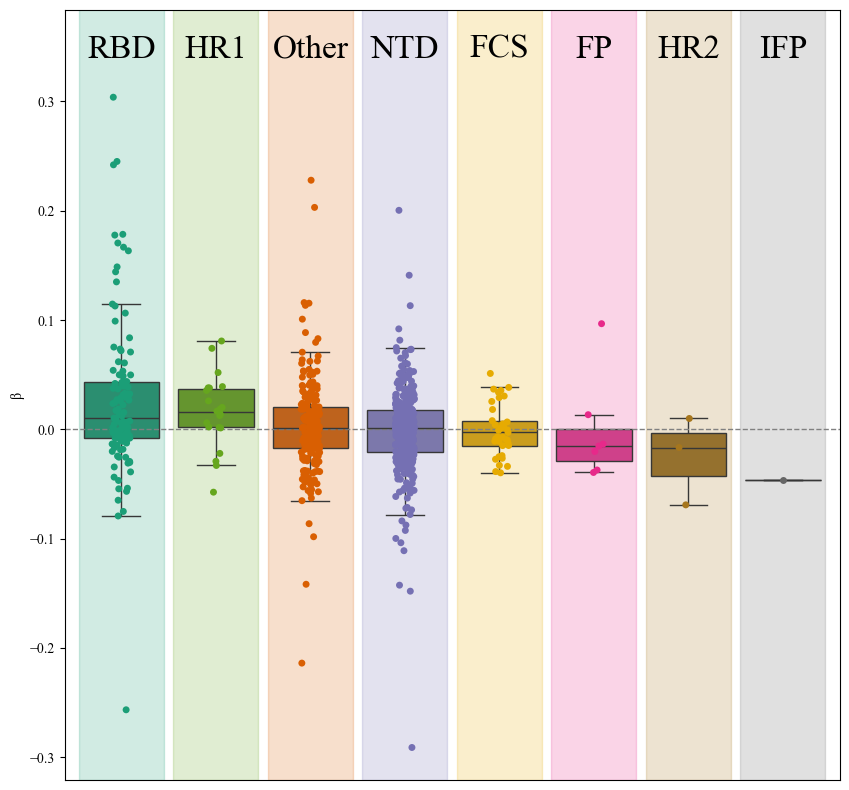

In [377]:
fig, ax = plt.subplots(figsize=(0.5, 0.5))
escape_df, palette = lollipop(escape_df, ax, labels=True, space_func=space_func, orientation='vertical')


fig, ax = plt.subplots(figsize=(10,10))

region_order = escape_df[['Region', 'β']].groupby('Region').agg('mean').sort_values(by='β', ascending=False).index.tolist()#['NTD', 'RBD', 'FCS', 'FP', 'IFP', 'HR1', 'HR2', 'Other']
sns.boxplot(y='β',
            x='Region',
            hue='Region',
            data=escape_df,
            palette=palette,
            showfliers=False,
            order=region_order,
            ax=ax);
sns.stripplot(y='β',
            x='Region',
            hue='Region',
            data=escape_df,
            palette=palette,
            jitter=True,
            order=region_order,
            ax=ax);
ylim = ax.get_ylim()
for i, reg in enumerate(region_order):
    data = escape_df[escape_df['Region']==reg]['β'].values
    D, p_val = kstest(data, 'laplace', (0, sb)) 
    label = 'p < 0.05' if p_val<0.05 else '- -'
    ax.text(i, ylim[1], reg, fontsize=24, ha='center', va='bottom')
    # ax.text(i, ylim[1], label, fontsize=10, ha='center', va='top')
    ax.fill_between([i-0.45, i+0.45], [ylim[0], ylim[0]], [1.2*ylim[1], 1.2*ylim[1]], color=palette[reg], alpha=0.2, zorder=-1)
ax.set_ylim([ylim[0], 1.15*ylim[1]]);
ax.set_xlim([-0.6, len(region_order)-1+0.6]);
ax.set_xticks([]);
ax.set_xlabel('');
    
xlim = ax.get_xlim()
ax.hlines(0, xlim[0], xlim[1], color='gray', linestyle='--', linewidth=1);
ax.set_xlim(xlim);

fig.savefig('figs/ALTERNATE_FIGURE_1/mut_boxplot.png', dpi=350)

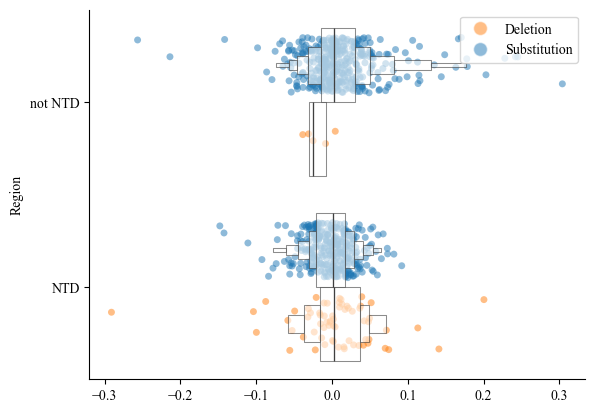

In [19]:
del_df = escape_df.copy()
del_df['Deletion'] = del_df['Mutation'].apply(lambda x: 'del' in x or 'Δ' in x if isinstance(x, str) else False)
del_df['Region'] = del_df['Region'].apply(lambda x: x if x=='NTD' else 'not NTD')
fig, ax = plt.subplots()
sns.boxenplot(y='Region',
              x='β',
              hue='Deletion',
              data=del_df,
              alpha=0.6,
              showfliers=False,
              facecolor='white',
              ax=ax)
sns.stripplot(y='Region',
              x='β',
              hue='Deletion',
              data=del_df,
              jitter=0.3,
              dodge=True,
              alpha=0.5,
              zorder=-1,
              ax=ax);
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Deletion',
           markerfacecolor='tab:orange', markersize=10, alpha=0.5),
    Line2D([0], [0], marker='o', color='w', label='Substitution',
           markerfacecolor='tab:blue', markersize=10, alpha=0.5)
]
ax.legend(handles=legend_elements, loc='upper right')
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('');

In [20]:
def normal(x, μ, σ):
    kern = (x - μ)**2 / (2*σ**2)
    return 1 / np.sqrt(2*np.pi*σ**2) * np.exp(-kern)

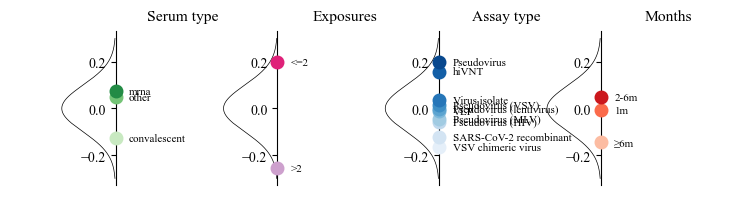

In [21]:
fig, axes = plt.subplots(1, 4, figsize=(8, 2))
fs = 16
ylim = [-0.3, 0.3]
biases = {'Serum type': {'map_label': 'serum_type_map', 
                         'trace_label': 'S',
                         'colors': 'Greens_r'},
          'Exposures':  {'map_label': 'exposures_map', 
                         'trace_label': 'E',
                         'colors': 'PuRd_r'},
          'Assay type': {'map_label': 'assay_type_map', 
                         'trace_label': 'A',
                         'colors': 'Blues_r'},
          'Months': {'map_label': 'months_map', 
                         'trace_label': 'M',
                         'colors': 'Reds_r'}}


for i, bias in enumerate(biases.keys()):
    ax = axes[i]
    ### Plot prior
    y = np.linspace(ylim[0], ylim[1], 500)
    norm_scale = 0.1
    x = norm_scale*normal(y, 0, norm_scale)
    ax.plot(x, y, color='k', linewidth=0.5, clip_on=False)
    ax.set_xlim([0, -1]);
    #### Plot points
    # Format data
    bias_df = pd.DataFrame(data=escape_traces[biases[bias]['trace_label']], columns=escape_data[biases[bias]['map_label']])
    bias_df = bias_df.melt(var_name=bias)
    bias_mean_df = bias_df.groupby(bias).agg('mean').rename(columns={'value':'mean'}).reset_index()
    bias_df = pd.merge(bias_df, bias_mean_df).sort_values(by='mean', ascending=False).reset_index(drop=True)
    # Make color palette
    sorted_vals = bias_df[bias].unique().tolist()
    palette = {v:c for v, c in zip(sorted_vals, sns.color_palette(biases[bias]['colors'], len(sorted_vals)))}
    # Plot means
    sns.pointplot(x=0,
                  y='value',
                  hue=bias,
                  hue_order=sorted_vals[::-1],
                  data=bias_df,
                  errorbar=('ci', 95),
                  markersize=ms,
                  clip_on=False,
                  palette=palette,
                  zorder=100,
                  native_scale=True,
                  ax=ax);
    ax.set_ylabel('');
    ax.legend().set_visible(False);
    # Label points
    for _, row in bias_mean_df.iterrows():
        ax.text(-0.1, row['mean'], row[bias], 
                fontsize=fs/2, ha='left', va='center')

    ax.set_xticks([]);
    ax.spines[['top', 'bottom', 'right']].set_visible(False);
    ax.set_title(bias, fontsize=0.7*fs, va='bottom'); 

In [22]:
def space_func(values, spacer=0.065):
    """Partitions values into components and evenly spaces each"""
    components = []
    curr_comp = [values[0]]

    for i in range(1, len(values)):
        if abs(values[i] - values[i - 1]) <= spacer:
            curr_comp.append(values[i])
        else:
            components.append(curr_comp)
            curr_comp = [values[i]]
    components.append(curr_comp)

    # Apply linspace to each component
    spaced_values = []
    for comp in components:
        # to avoid components not crossing each other after spacing, must augment spacing by less than half the spacer on each side
        # if augmenting by more than half the spacer on each side, the top side of spaced_values for one components may cross the bottom 
        #     side of spaced_values for another component
        spaced = np.linspace(min(comp) - spacer, max(comp) + spacer, len(comp)+2)[1:-1]   
        # spaced = np.linspace(min(comp) - 0.45*spacer, max(comp) + 0.45*spacer, len(comp))
        spaced_values.extend(spaced)

    return spaced_values

def recursive_space_func(values, spacer=0.065):
    """
    Recursively applies space_func until values converge or max_iter reached.
    """
    assert np.allclose(sorted(values), values), 'Please sort values'
    spaced_values = space_func(values, spacer=spacer)
    # if np.allclose(spaced_values, values, atol=1e-8):
    #     return spaced_values
    if not np.allclose(spaced_values, values, atol=1e-10):
        spaced_values = recursive_space_func(spaced_values, spacer=spacer)
    # spaced_values = recursive_space_func(spaced_values)
    return spaced_values
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


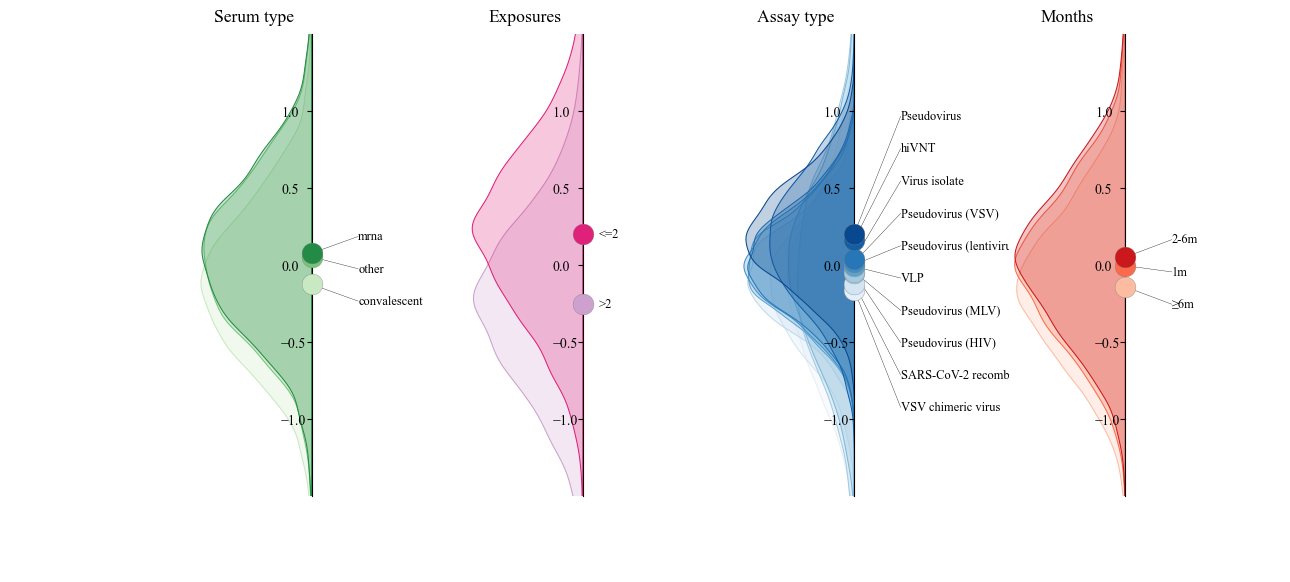

In [23]:
fig, axes = plt.subplots(1, 2*4, figsize=(14, 6), gridspec_kw={'width_ratios':[1.5, 2]*4})
fig.subplots_adjust(wspace=0);
fs = 18
ms=15
ylim = [-1.5, 1.5]
biases = {'Serum type': {'map_label': 'serum_type_map', 
                         'trace_label': 'S',
                         'colors': 'Greens_r'},
          'Exposures':  {'map_label': 'exposures_map', 
                         'trace_label': 'E',
                         'colors': 'PuRd_r'},
          'Assay type': {'map_label': 'assay_type_map', 
                         'trace_label': 'A',
                         'colors': 'Blues_r'},
          'Months': {'map_label': 'months_map', 
                         'trace_label': 'M',
                         'colors': 'Reds_r'}}


for i, bias in enumerate(biases.keys()):
    ax = axes[2*i]
    ### Format data
    bias_df = pd.DataFrame(data=escape_traces[biases[bias]['trace_label']], columns=pd.Series(escape_data[biases[bias]['map_label']]).fillna('Unknown').tolist())
    bias_df = bias_df.melt(var_name=bias)
    bias_mean_df = bias_df.groupby(bias).agg('mean').rename(columns={'value':'mean'}).reset_index()
    bias_df = pd.merge(bias_df, bias_mean_df).sort_values(by='mean', ascending=False).reset_index(drop=True)
    # Make color palette
    sorted_vals = bias_df[bias].unique().tolist()
    palette = {v:c for v, c in zip(sorted_vals, sns.color_palette(biases[bias]['colors'], len(sorted_vals)))}
    ### Plot trace
    sns.kdeplot(y='value',
                hue=bias,
                hue_order=sorted_vals,#[::-1],
                data=bias_df,
                palette=palette,
                linewidth=0.75,
                fill=True,
                alpha=0.25,
                ax=ax)
    ax.set_xlim([ax.get_xlim()[1], 0]);
    ax.set_xticks([]);
    ax.set_yticks(np.linspace(ylim[0], ylim[1], 7)[1:-1]);
    ax.yaxis.tick_right();
    ax.tick_params(axis="y",direction="in", pad=-22);
    ax.spines[['top', 'bottom', 'left']].set_visible(False);
    ax.set_title(bias, fontsize=0.7*fs, va='bottom'); 
    
    #### Plot points
    ax = axes[2*i+1]
    sns.pointplot(x=0,
                  y='value',
                  hue=bias,
                  hue_order=sorted_vals[::-1],
                  data=bias_df,
                  errorbar=('ci', 95),
                  markersize=ms,
                  clip_on=False,
                  markeredgecolor='gray',
                  markeredgewidth=0.25,
                  palette=palette,
                  zorder=100,
                  native_scale=True,
                  ax=ax);
    # Label points
    labels = bias_mean_df[bias].values
    values = bias_mean_df['mean'].values
    labels, values = zip(*sorted(zip(labels, values), key=lambda x: x[1]))
    spaced_values = recursive_space_func(values, spacer=0.21)
    
    # Annotate if spacing changes position
    if not np.allclose(spaced_values, values, atol=1e-1):
        ax.plot(np.array([[0]*len(values), 
                          [0.3]*len(values)]), 
                np.array([values, 
                          spaced_values]), 
                color='k', linewidth=0.25);
        for l, v in zip(labels, spaced_values):
            ax.text(0.3, v, l,
                    fontsize=fs/2, ha='left', va='center')
    else:
        for _, row in bias_mean_df.iterrows():
            ax.text(0.1, row['mean'], row[bias], 
                    fontsize=fs/2, ha='left', va='center')
    ax.set_xlim([0, 1]);
    ax.axis('off');
    
    
    for ax in axes[2*i:2*(i+1)]:
        ax.legend().set_visible(False);
        ax.set_ylabel('');
        ax.set_xlabel('');
        ax.set_ylim(ylim);

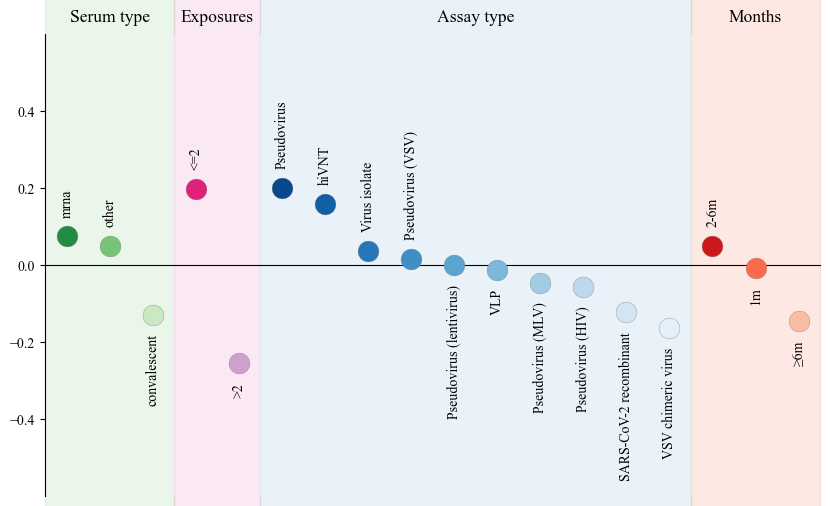

In [37]:
fig, axes = plt.subplots(1, 4, figsize=(10, 6), gridspec_kw={'width_ratios':[len(escape_data[biases[bias]['map_label']]) for bias in biases.keys()]})
fig.subplots_adjust(wspace=0);
fs = 18
ms=15
ylim = [-0.6, 0.6]
biases = {'Serum type': {'map_label': 'serum_type_map', 
                         'trace_label': 'S',
                         'colors': 'Greens_r'},
          'Exposures':  {'map_label': 'exposures_map', 
                         'trace_label': 'E',
                         'colors': 'PuRd_r'},
          'Assay type': {'map_label': 'assay_type_map', 
                         'trace_label': 'A',
                         'colors': 'Blues_r'},
          'Months': {'map_label': 'months_map', 
                         'trace_label': 'M',
                         'colors': 'Reds_r'}}


for i, bias in enumerate(biases.keys()):
    ax = axes[i]
    ### Format data
    bias_df = pd.DataFrame(data=escape_traces[biases[bias]['trace_label']], columns=pd.Series(escape_data[biases[bias]['map_label']]).fillna('Unknown').tolist())
    bias_df = bias_df.melt(var_name=bias)
    bias_mean_df = bias_df.groupby(bias).agg('mean').rename(columns={'value':'mean'}).reset_index()
    bias_df = pd.merge(bias_df, bias_mean_df).sort_values(by='mean', ascending=False).reset_index(drop=True)
    # Make color palette
    sorted_vals = bias_df[bias].unique().tolist()
    palette = {v:c for v, c in zip(sorted_vals, sns.color_palette(biases[bias]['colors'], len(sorted_vals)))}
    #### Plot points
    sns.pointplot(x=bias,
                  y='mean',
                  hue=bias,
                  hue_order=sorted_vals[::-1],
                  data=bias_df,
                  errorbar=('ci', 95),
                  markersize=ms,
                  clip_on=False,
                  markeredgecolor='gray',
                  markeredgewidth=0.25,
                  palette=palette,
                  zorder=100,
                  native_scale=True,
                  ax=ax);
    
    for xi, label in enumerate(sorted_vals):
        yi = bias_mean_df[bias_mean_df[bias]==label]['mean'].values.item()
        if yi>0:
            yi += 0.05
            va = 'bottom'
        else:
            yi -= 0.05
            va = 'top'
        ax.text(xi, yi, label, 
                ha='center', va=va,
                rotation=90);
    
    ax.set_ylim(ylim);
    ax.set_yticks([]);
    ax.set_ylabel('');
    ax.spines[['top', 'right', 'left']].set_visible(False);
    ax.spines['bottom'].set_position('zero');
    ax.set_xticks([]);
    ax.set_xlabel('');
    ax.set_title(bias, fontsize=0.7*fs, va='bottom');
    if i == 0:
        ax.spines[['left']].set_visible(True);
        ax.set_yticks(np.linspace(ylim[0], ylim[1], 7)[1:-1]);
        
    xlim = ax.get_xlim()
    ax.fill_between(xlim, [ylim[0]*1.5, ylim[0]*1.5], [ylim[1]*1.5, ylim[1]*1.5], 
                    clip_on=False,
                    color=sns.color_palette(biases[bias]['colors'], 1),
                    alpha=0.15)
    ax.set_xlim(xlim); 
    ax.set_ylim(ylim);
fig.savefig('figs/ALTERNATE_FIGURE_1/bias_effects.png', dpi=200)

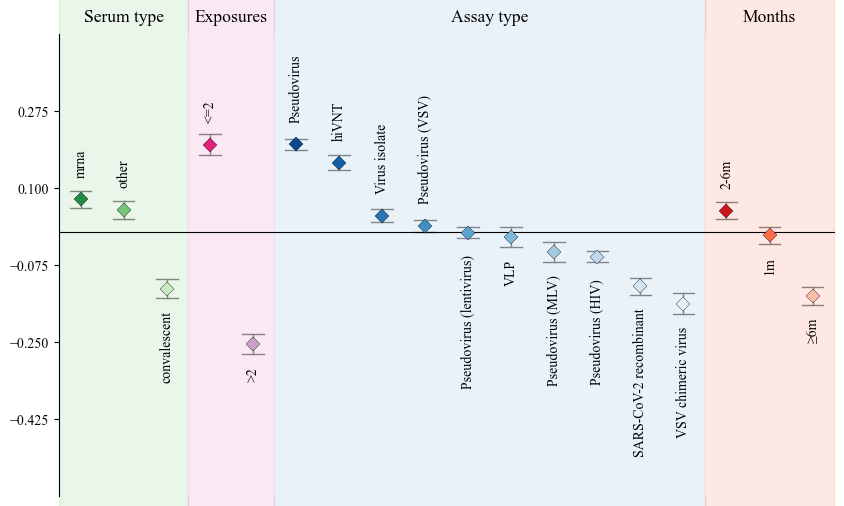

In [63]:
fig, axes = plt.subplots(1, 4, figsize=(10, 6), gridspec_kw={'width_ratios':[len(escape_data[biases[bias]['map_label']]) for bias in biases.keys()]})
fig.subplots_adjust(wspace=0);
fs = 18
ms=15
ylim = [-0.6, 0.45]
biases = {'Serum type': {'map_label': 'serum_type_map', 
                         'trace_label': 'S',
                         'colors': 'Greens_r'},
          'Exposures':  {'map_label': 'exposures_map', 
                         'trace_label': 'E',
                         'colors': 'PuRd_r'},
          'Assay type': {'map_label': 'assay_type_map', 
                         'trace_label': 'A',
                         'colors': 'Blues_r'},
          'Months': {'map_label': 'months_map', 
                         'trace_label': 'M',
                         'colors': 'Reds_r'}}


for i, bias in enumerate(biases.keys()):
    ax = axes[i]
    ### Format data
    bias_df = pd.DataFrame(data=escape_traces[biases[bias]['trace_label']], columns=pd.Series(escape_data[biases[bias]['map_label']]).fillna('Unknown').tolist())
    bias_df = bias_df.melt(var_name=bias)
    bias_mean_df = bias_df.groupby(bias).agg('mean').rename(columns={'value':'mean'}).reset_index()
    bias_df = pd.merge(bias_df, bias_mean_df).sort_values(by='mean', ascending=False).reset_index(drop=True)
    # Make color palette
    sorted_vals = bias_df[bias].unique().tolist()
    palette = {v:c for v, c in zip(sorted_vals, sns.color_palette(biases[bias]['colors'], len(sorted_vals)))}
    #### Plot points
    sns.pointplot(x=bias,
                  y='value',
                  hue=bias,
                  hue_order=sorted_vals[::-1],
                  data=bias_df,
                  errorbar=('ci', 99),
                  capsize=0.5,
                  linewidth=1,
                  err_kws={'color':'gray', 'zorder':-1},
                  markersize=ms/2,
                  marker='D',
                  clip_on=False,
                  markeredgecolor='black',
                  markeredgewidth=0.25,
                  palette=palette,
                  zorder=100,
                  native_scale=True,
                  ax=ax);
    
    for xi, label in enumerate(sorted_vals):
        yi = bias_mean_df[bias_mean_df[bias]==label]['mean'].values.item()
        if yi>0:
            yi += 0.05
            va = 'bottom'
        else:
            yi -= 0.05
            va = 'top'
        ax.text(xi, yi, label, 
                ha='center', va=va,
                rotation=90);
    
    ax.set_ylim(ylim);
    ax.set_yticks([]);
    ax.set_ylabel('');
    ax.spines[['top', 'right', 'left']].set_visible(False);
    ax.spines['bottom'].set_position('zero');
    ax.set_xticks([]);
    ax.set_xlabel('');
    ax.set_title(bias, fontsize=0.7*fs, va='bottom');
    if i == 0:
        ax.spines[['left']].set_visible(True);
        ax.set_yticks(np.linspace(ylim[0], ylim[1], 7)[1:-1]);
        
    xlim = ax.get_xlim()
    ax.fill_between(xlim, [ylim[0]*1.5, ylim[0]*1.5], [ylim[1]*1.5, ylim[1]*1.5], 
                    clip_on=False,
                    color=sns.color_palette(biases[bias]['colors'], 1),
                    alpha=0.15)
    ax.set_xlim(xlim); 
    ax.set_ylim(ylim);
fig.savefig('figs/ALTERNATE_FIGURE_1/bias_effects_CI.png', dpi=200)